In [1]:
from koopman_probabilistic import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mu_vec = 2 * np.sin(2 * np.pi / 24 * np.arange(5000))
sigma_vec = 3 * np.cos(2 * np.pi / 36 * np.arange(5000) + 1.5) + 3
rng = np.random.default_rng()
x = rng.normal(mu_vec, sigma_vec).astype(np.float32)
x = np.expand_dims(x, 1)
data_name = "sin"

predict_through = len(x)
train_through = 4000

num_mu = 2
num_sig = 2
num_fourier = 1
mu_file = "forecasts//" + data_name + f"_{num_mu}mu.npy"
sigma_file = "forecasts//" + data_name + f"_{num_sig}sigma.npy"

In [7]:
model = FullyConnectedNLL(x_dim=1, num_freqs_mu=num_mu, num_freqs_sigma=num_sig, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier)
xt = x[:train_through]
k.find_fourier_omegas(xt)

fourier omegas: tensor([24.0964], dtype=torch.float64)


In [19]:
k.fit(xt, iterations=100, interval=20, verbose=True, cutoff=0, weight_decay=1e-4)  # slice must be at least batch size=1000
mu_hat, sigma_hat = k.predict(predict_through)
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)

Iteration  0
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1412997
Iteration  1
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1412995
Iteration  2
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1412983
Iteration  3
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1412909
Iteration  4
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1412562
Iteration  5
tensor([23.9919, 36.0176, 24.0079, 35.9728])
Setting periods to tensor([23.9919, 36.0176, 24.0079, 35.9728], grad_fn=<MulBackward0>)
Loss:  1.1411325
Iteration  6
tensor([2

Setting periods to tensor([23.9901, 36.0234, 24.0053, 35.9700], grad_fn=<MulBackward0>)
Loss:  1.1111798
Iteration  51
tensor([23.9901, 36.0234, 24.0053, 35.9700])
Setting periods to tensor([23.9866, 36.0292, 24.0011, 35.9624], grad_fn=<MulBackward0>)
Loss:  1.175864
Iteration  52
tensor([23.9866, 36.0292, 24.0011, 35.9624])
Setting periods to tensor([23.9897, 36.0228, 24.0047, 35.9671], grad_fn=<MulBackward0>)
Loss:  1.1111716
Iteration  53
tensor([23.9897, 36.0228, 24.0047, 35.9671])
Setting periods to tensor([23.9869, 36.0280, 24.0046, 35.9600], grad_fn=<MulBackward0>)
Loss:  1.1620792
Iteration  54
tensor([23.9869, 36.0280, 24.0046, 35.9600])
Setting periods to tensor([23.9887, 36.0251, 24.0037, 35.9679], grad_fn=<MulBackward0>)
Loss:  1.1437051
Iteration  55
tensor([23.9887, 36.0251, 24.0037, 35.9679])
Setting periods to tensor([23.9902, 36.0145, 24.0063, 35.9734], grad_fn=<MulBackward0>)
Loss:  1.2396305
Iteration  56
tensor([23.9902, 36.0145, 24.0063, 35.9734])
Setting periods t

In [ ]:
mu_hat = np.load(mu_file)
sigma_hat = np.load(sigma_file)

<IPython.core.display.Javascript object>


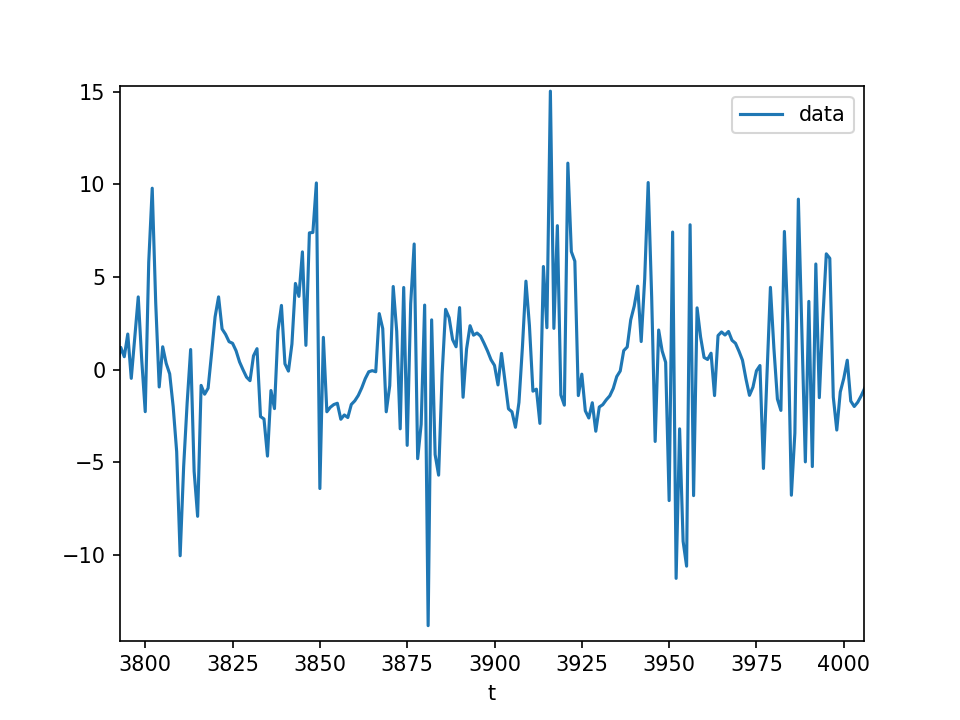

In [23]:
# print("SEED:", seed)
%matplotlib notebook
# slc = -2400
# plt.scatter(np.arange(-slc), x[slc:], label="data")
plt.plot(x[:predict_through], label="data")
plt.plot(mu_hat, label="koopman")
plt.plot(mu_hat + sigma_hat, "--", color="black", label="koopman 68% CI")
plt.plot(mu_hat - sigma_hat, "--", color="black")

# plt.plot(mu_vec[slc:], label="real mu")
# plt.plot(mu_hat[slc:, 0], label="koopman mu")
# plt.legend()
# plt.show()
#
# plt.plot(sigma_vec[slc:], label="real sigma")
# plt.plot(sigma_hat, label="koopman sigma")
plt.title(f"{num_mu}mu{num_sig}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [10]:
k.omegas = -k.omegas

In [11]:
temp = k.omegas

<IPython.core.display.Javascript object>


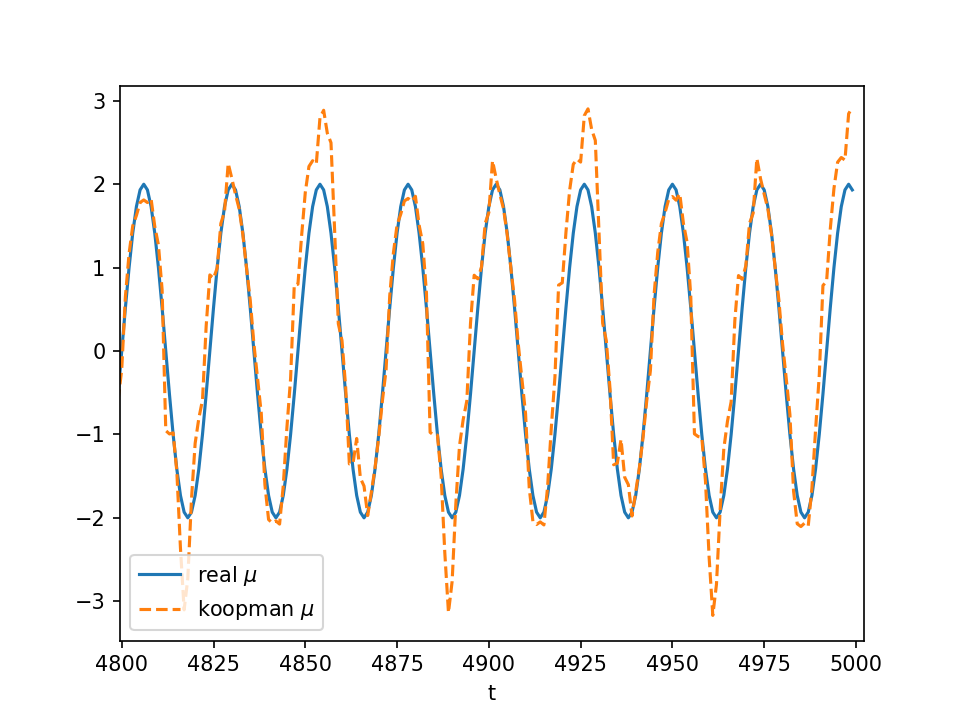

In [21]:
plt.figure()
plt.plot(mu_vec, label="real $\mu$")
plt.plot(mu_hat[:, 0], "--", label="koopman $\mu$")
plt.xlabel("t")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


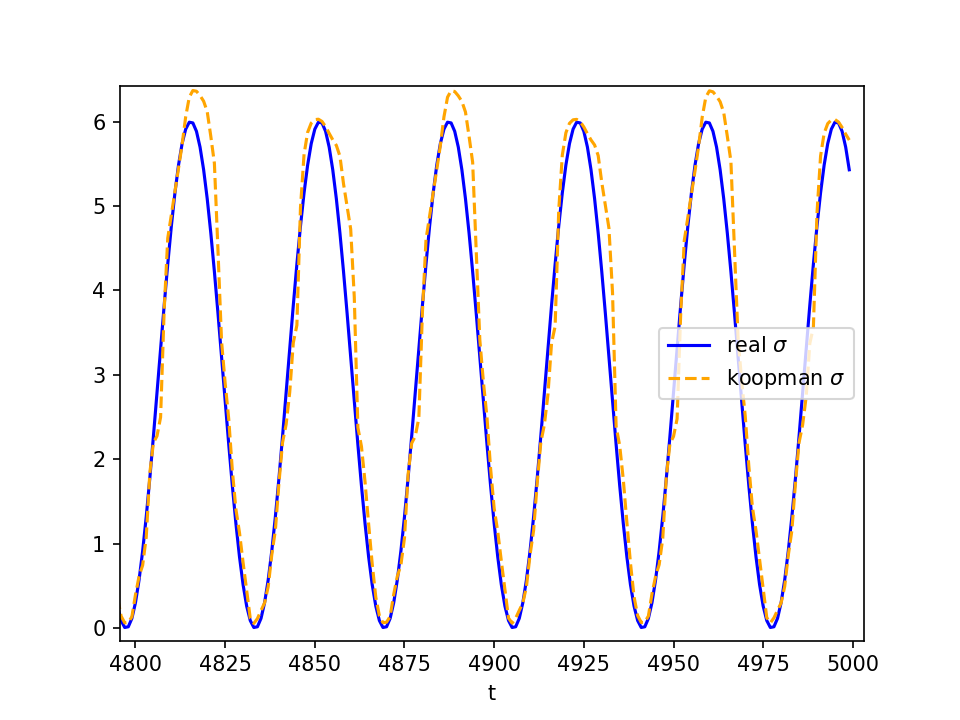

In [22]:
plt.figure()
plt.plot(sigma_vec, color="blue", label="real $\sigma$")
plt.plot(sigma_hat[:, 0], "--", color="orange", label="koopman $\sigma$")
plt.xlabel("t")
plt.legend()
plt.show()

In [5]:
help(torch.unsqueeze)

Help on built-in function unsqueeze:

unsqueeze(...)
    unsqueeze(input, dim) -> Tensor
    
    Returns a new tensor with a dimension of size one inserted at the
    specified position.
    
    The returned tensor shares the same underlying data with this tensor.
    
    A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
    can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
    applied at :attr:`dim` = ``dim + input.dim() + 1``.
    
    Args:
        input (Tensor): the input tensor.
        dim (int): the index at which to insert the singleton dimension
    
    Example::
    
        >>> x = torch.tensor([1, 2, 3, 4])
        >>> torch.unsqueeze(x, 0)
        tensor([[ 1,  2,  3,  4]])
        >>> torch.unsqueeze(x, 1)
        tensor([[ 1],
                [ 2],
                [ 3],
                [ 4]])



In [71]:
# Construct pdf quantiles
# REMOVE
sigma = 1 * np.cos(2 * np.pi / 36 * np.arange(5000) + 1.5) + 4

num_quantiles = 100
domain = [min(mu_hat[:,0] - 2.5*sigma), max(mu_hat[:,0] + 2.5*sigma)]
x_axis = np.linspace(domain[0], domain[1], num_quantiles)

In [43]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

In [45]:
def polygon_under_graph(xlist, zlist):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (xlist, ylist) line graph.  Assumes the xs are in ascending order.
    """
    return [(xlist[0], 0.), *zip(xlist, zlist), (xlist[-1], 0.)]

<IPython.core.display.Javascript object>


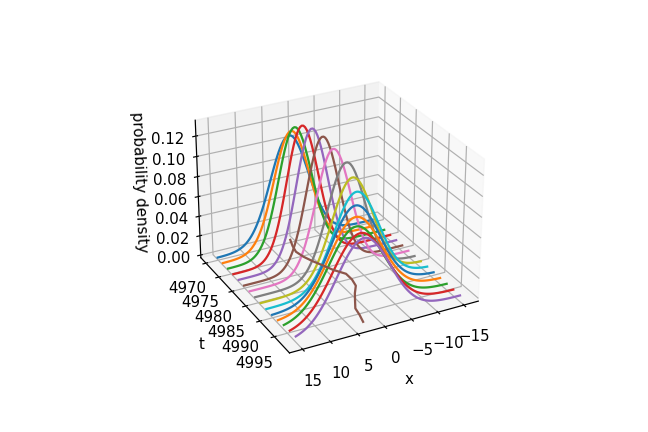

In [78]:
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
verts = []
ts = range(4970, 5000, 2)
for t in ts:
    z = normal_pdf(mu_hat[t], sigma[t], x_axis)
    plt.plot(x_axis, t*np.ones(num_quantiles), z)
    verts.append(polygon_under_graph(x_axis, z))

plt.plot(mu_hat[4970:5000:2, 0], ts, np.zeros(len(ts)))

# poly = PolyCollection(verts, facecolors=['r', 'g', 'b', 'y'], alpha=.6)
# ax.add_collection3d(poly, zs=ts, zdir='y')
plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("probability density")


plt.show()